In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


google_drive_mount_path = '/content/gdrive'


import numpy as np
import json
import pandas as pd
import os

from zipfile import ZipFile 

import tensorflow as tf


from pathlib import Path

import gc
import math
import cv2
import PIL
from PIL import Image

import matplotlib.pyplot as plt

import scipy
from tqdm.notebook import tqdm
%matplotlib inline
from keras.preprocessing import image

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.image import resize

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
import seaborn as sns


google_drive_shared_path = os.path.join(google_drive_mount_path, 'My Drive' , 'Thesis/Data')

print(tf.__version__)

Mounted at /content/gdrive
2.3.0


#GradCAM function

In [ ]:
def grad_cam(model,layer_name,img,num_label):
 
    grad_model = tf.keras.models.Model([model.input], [model.get_layer(name= layer_name).output,model.output])

    with tf.GradientTape() as g:
        conv_outputs,predictions = grad_model(np.array([img]))
        loss = predictions[:, num_label]
        
    output = conv_outputs[0]
    grads = g.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]


    cam = cv2.resize(cam.numpy(), (224, 224))
    check = cam
    cam = np.maximum(cam, 0)

    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    #cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_VIRIDIS)
    
    #output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)
    output_image = cv2.addWeighted(cv2.cvtColor(np.uint8(img*255), cv2.COLOR_RGB2BGR), 0.3, cam, 0.7, 0)

    return cam , output_image

#Loading the model

You need to load the model h5 model

In [ ]:
model_name= "model_grad_cam"
dir = "challenge 2016 data/dataset/weighted/%s.hdf5" % model_name
checkpoint_path = os.path.join(google_drive_shared_path, dir) 

model= tf.keras.models.load_model(checkpoint_path)

#Visualization function 
The following function displays the images with the Gradient Class Activation Mapping for a random subset of 25 images from the ISIC 2016 dataset

In [ ]:
def pgd_grad_cam_visualization(layer_name,model_init,X_test,y_test,name) :

    fig = plt.figure(figsize=(15,15))


    range_ = np.random.randint(X_test.shape[0], size=25)
    i = 0
    for ind in range_:
        
        plt.subplot(5, 5, i + 1)
        i+=1
        image = X_test[ind] / 255.
        label_image = y_test[ind]
        gc = grad_cam(model_init,layer_name,image,label_image)
        

        
        predicted_label = np.argmax(model_init(tf.expand_dims(image,0)))
        confidence = tf.math.softmax(model_init(tf.expand_dims(image,0)))[:,predicted_label]*100
        
        #titles = ["GRAD-CAM"]


        plt.imshow(gc[1])
        
        plt.text(0, 2, s=f"y_true={labels[label_image]}",
                bbox=dict(facecolor='blue', alpha=0.9),
                color="white")
        color = "green" if predicted_label == label_image else "red"
        plt.text(0, 210, s=f"y_pred={labels[predicted_label]} confidence={confidence}",
              bbox=dict(facecolor=color, alpha=0.9),
              color="white")

   
        #plt.title(titles[i],fontdict={'fontsize':12})
        plt.axis("off")
    dir = "challenge 2016 data/dataset/weighted/%s.png" % name
    save_path = os.path.join(google_drive_shared_path, dir) 
    plt.savefig(save_path)
    plt.show()

#The results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


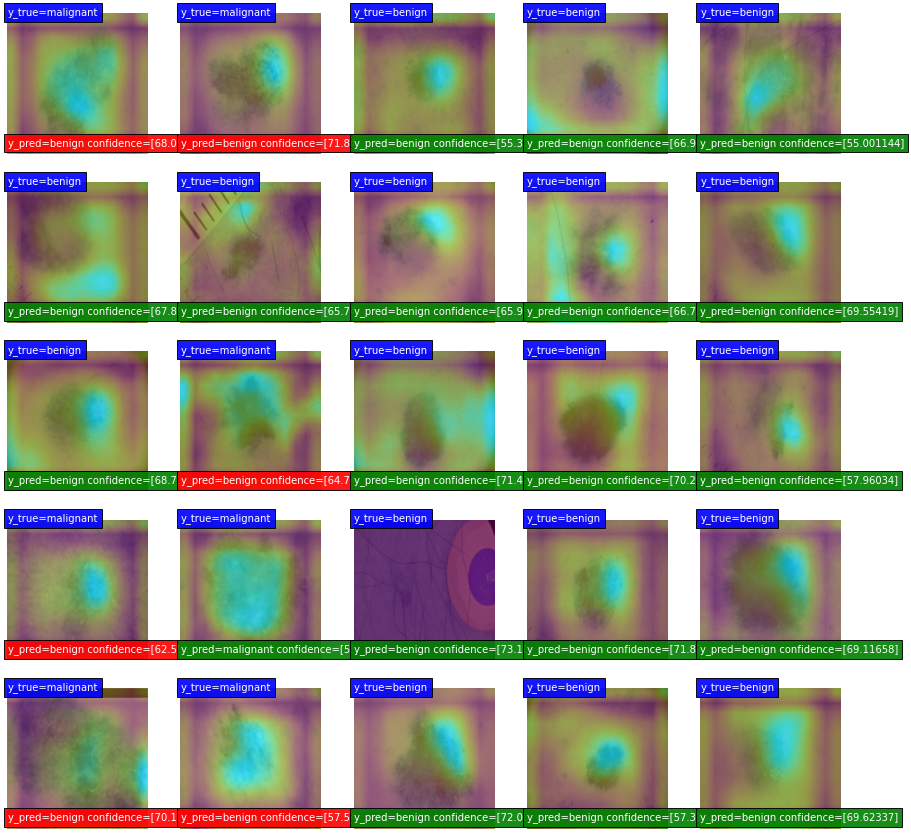

In [ ]:
layer_name = 'block5_conv3'
labels=['benign','malignant']

pgd_grad_cam_visualization(layer_name,model,X_test_224,y_test.astype('int32'),'gradcam_ft')

#The results for the malignant class

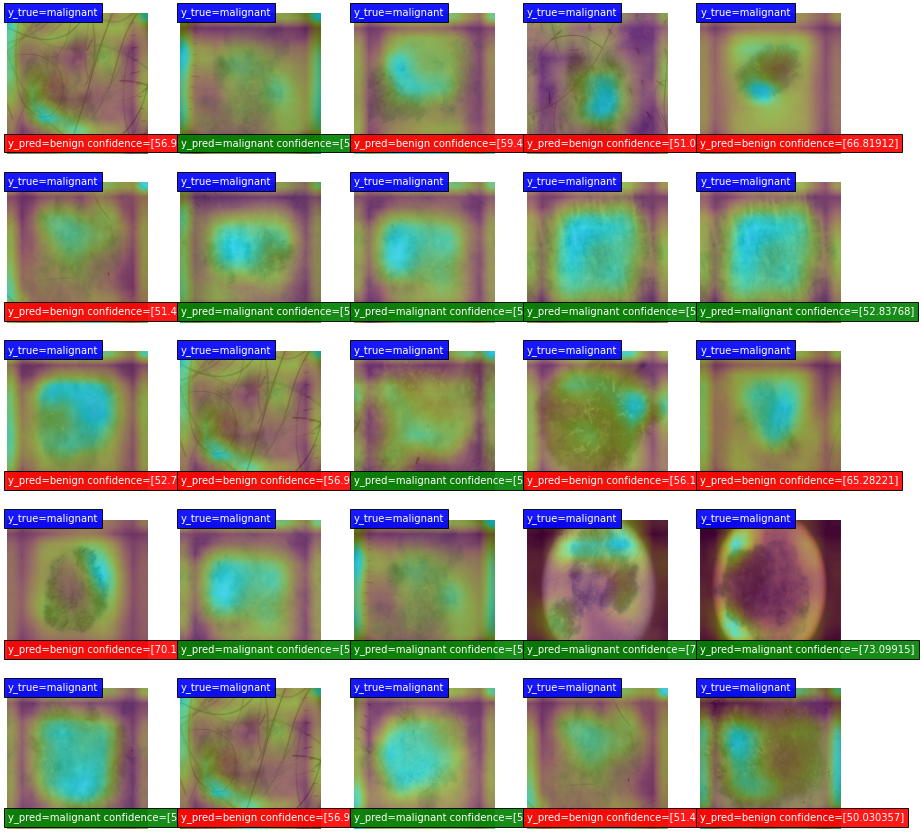

In [ ]:
y_malignant = y_test[np.where(y_test == 1)[0]]
y_malignant = y_malignant.astype('int32')
X_malignant = X_test_224[np.where(y_test == 1)[0]]

layer_name = 'block5_conv3'
labels=['benign','malignant']

pgd_grad_cam_visualization(layer_name,model,X_malignant,y_malignant,'gradcam_malignant')